In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sklearn.metrics as skm
from helper_functions import NUM2STR, STR2NUM
from helper_functions import mean_std, median_iqr, perc_transition

In [2]:
wdir = "output/cv"
wdir_demo = "output/demographics/"

In [3]:
# Choose model (set in config) -------------------
model = "eeg+eog+emg+demo"

df = pd.read_parquet(wdir + "/cv_loo_nsrr_shhs.parquet")
# df['subj'] = df['subj'].astype(str)
df_demo = pd.read_csv(wdir_demo + "shhs_demo.csv").set_index('subj')

In [4]:
df_demo

,age,male,bmi,ahi,ethnicity,set,hypertension
subj,,,,,,,
200077,41.0,1,23.388687,9.738220,caucasian,training,0.0
200078,54.0,1,30.211833,19.685039,caucasian,training,1.0
200079,56.0,0,35.451050,26.000000,other,testing,0.0


In [5]:
# Per each night
df_scores = []

labels = ['N1', 'N2', 'N3', 'R', 'W']

for sub in tqdm(df['subj'].unique(), leave=False):
    df_sub = df[df['subj'] == sub]
    yt = df_sub['y_true']
    yp = df_sub['y_pred']
    n = yt.shape[0]

    sub_scores = {
        # Accuracy
        'accuracy': 100 * skm.accuracy_score(yt, yp),
        'kappa': 100 * skm.cohen_kappa_score(yt, yp, labels=labels),
        'mcc': 100 * skm.matthews_corrcoef(yt, yp),
        'f1_macro': 100 * skm.f1_score(yt, yp, labels=labels, average='macro', zero_division=1),
        # % Transitions
        'dur_hours': (yt.size / 2) / 60,
        'perc_trans_true': perc_transition(yt),
        'perc_trans_pred': perc_transition(yp),
        # Confidence
        'avg_confidence': 100 * df_sub['confidence'].mean()
    }

    # F1 for each stage
    f1 = 100 * skm.f1_score(yt, yp, average=None, labels=labels, zero_division=1)
    for f, l in zip(f1, labels):
        sub_scores['f1_' + l] = f
        
    # In the case of an error, is the second-highest probability typically the correct one?
    error = (yp != yt).to_numpy()
    sub_scores['accuracy_second'] = 100 * skm.accuracy_score(yt[error], df_sub['y_pred_second'][error])

    # Proportion of each stage (NaN = 0)
    prop_true = (yt.value_counts() / n).add_prefix('perc_').add_suffix('_true')
    prop_pred = (yp.value_counts() / n).add_prefix('perc_').add_suffix('_pred')
    sub_scores.update(prop_true.to_dict())
    sub_scores.update(prop_pred.to_dict())

    # Append to main dataframe
    df_scores.append(pd.DataFrame(sub_scores, index=[sub]))


df_scores = pd.concat(df_scores)
df_scores.sort_index(axis=1, inplace=True)
df_scores.index.name = 'subj'

# Join with demographics
df_scores = df_scores.join(df_demo, how="left")

In [6]:
cmap = list(sns.color_palette("Blues", n_colors=10, as_cmap=False, desat=1))
color_pred = cmap[-1]
color_ref = "tab:orange"
cmap_stages = ['#99d7f1', '#009DDC', 'xkcd:twilight blue', 'xkcd:rich purple', 'xkcd:sunflower']

In [7]:
df_scores

,accuracy,accuracy_second,avg_confidence,dur_hours,f1_N1,f1_N2,f1_N3,f1_R,f1_W,f1_macro,...,perc_W_true,perc_trans_pred,perc_trans_true,age,male,bmi,ahi,ethnicity,set,hypertension
subj,,,,,,,,,,,,,,,,,,,,,
200079,74.689165,72.631579,97.888296,9.383333,39.08046,75.559701,0.0,82.075472,93.521127,58.047352,...,0.308171,11.634103,17.49556,56.0,0,35.45105,26.0,other,testing,0.0


<ipython-input-8-4e9e1aa057a2>:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


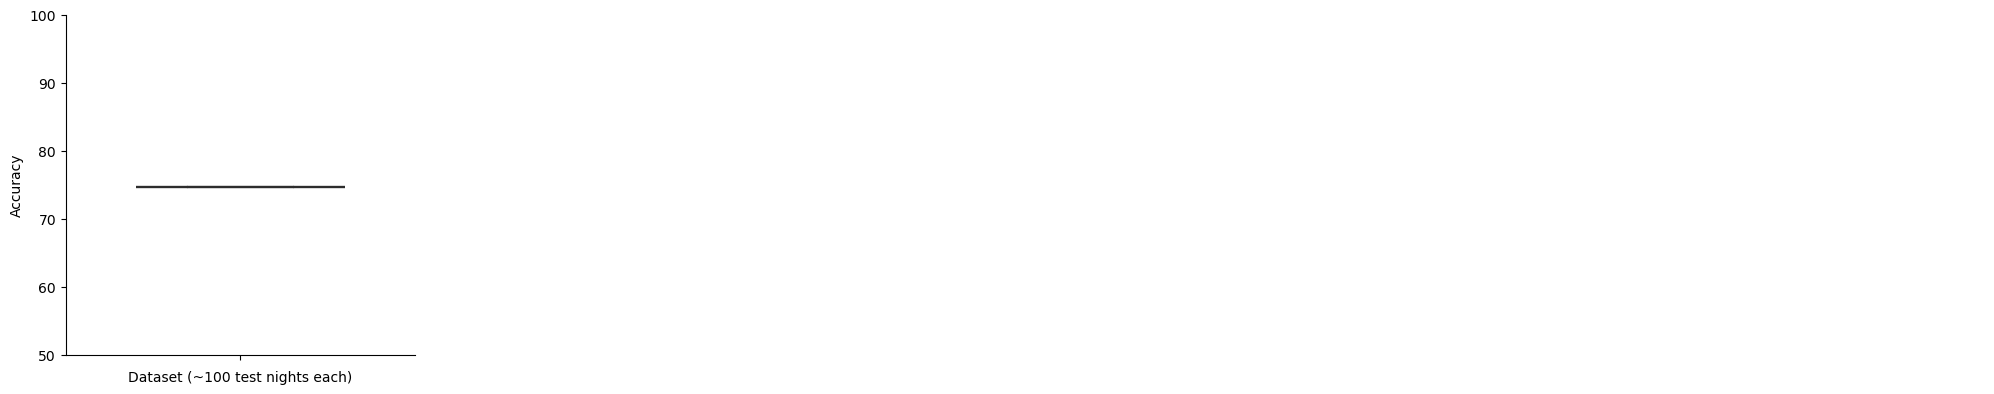

In [8]:
# Boxplot of accuracy
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
# order = df_scores['accuracy'].median().sort_values(ascending=False).index

ax1 = sns.boxplot(data=df_scores.reset_index(), y='accuracy', color=color_pred, saturation=1, 
                  fliersize=0, width=0.6, notch=True, linewidth=1.5)
                  # boxprops=dict(edgecolor="k"))

# plt.title("Performance on testing set (n=%i)" % df_scores.shape[0])
plt.xlabel("Dataset (~100 test nights each)")
plt.ylabel("Accuracy")
plt.ylim(50, 100)

ax.annotate("Accuracy (median): %.2f\nKappa (median): %.2f" % 
            (df_scores['accuracy'].median(), df_scores['kappa'].median()),
            xy=(5, 55), ha="right", fontstyle="italic", fontweight="semibold")

sns.despine()
plt.tight_layout()
plt.show()#savefig(outdir + "cv_boxplot_accuracy_datasets.png", dpi=300, bbox_inches="tight")